# Evaluating Bayesian Denoising Autoencoder on MNIST, EMNIST and Fashion-MNIST dataset


## Data loading and processing

Installing packages

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
!pip install -q tensorflow
%load_ext tensorboard

from skimage.metrics import structural_similarity as ssim

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

Switch to GPU if needed

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Load data

In [ ]:
transform = transforms.ToTensor()

test_data_mnist = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=False,
                                  download=True, transform=transform)
test_data_emnist = datasets.EMNIST(
                root='./data',
                download=True,
                split='letters',
                train=False,
                transform=transforms.Compose([
                    lambda img: transforms.functional.rotate(img, -90),
                    lambda img: transforms.functional.hflip(img),
                    transforms.ToTensor()
                ])
            )

test_data_fashion = datasets.FashionMNIST(root='data', train=False,
                                     download=True, transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4593967.74it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 135176.17it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1252447.55it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4087219.22it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



100%|██████████| 561753746/561753746 [00:29<00:00, 19136622.31it/s]


Extracting ./data/EMNIST/raw/gzip.zip to ./data/EMNIST/raw


100%|██████████| 26421880/26421880 [00:02<00:00, 9552764.13it/s] 


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 167001.51it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3129507.06it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6170985.14it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



Create dataloaders with batch size

In [ ]:
batch_size = 64

test_loader_mnist = torch.utils.data.DataLoader(test_data_mnist, batch_size=batch_size, shuffle=False)
test_loader_emnist = torch.utils.data.DataLoader(test_data_emnist, batch_size=batch_size, shuffle=False)
test_loader_fashion = torch.utils.data.DataLoader(test_data_fashion, batch_size=batch_size, shuffle=False)

Plot example images MNIST dataset

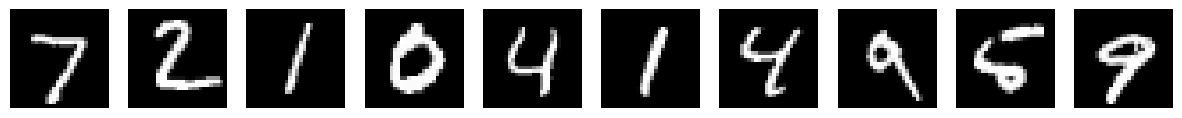

In [ ]:
# Get a batch of training data
data_iter = iter(test_loader_mnist)
images, labels = next(data_iter)

# Plot the first 10 images
fig, axes = plt.subplots(1, 10, figsize=(15, 1.5))
for i in range(10):
    ax = axes[i]
    ax.imshow(images[i].numpy().squeeze(), cmap='gray')
    ax.axis('off')

plt.show()

Plot example images Fashion-MNIST dataset

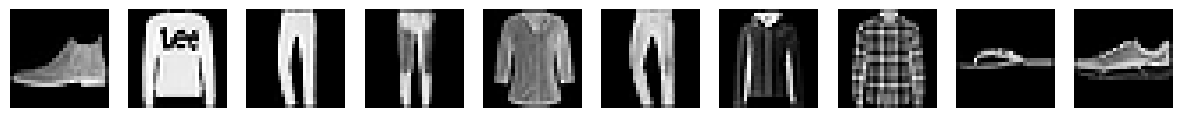

In [ ]:
# Get a batch of training data
data_iter = iter(test_loader_fashion)
images, labels = next(data_iter)

# Plot the first 10 images
fig, axes = plt.subplots(1, 10, figsize=(15, 1.5))
for i in range(10):
    ax = axes[i]
    ax.imshow(images[i].numpy().squeeze(), cmap='gray')
    ax.axis('off')

plt.show()

## Autoencoder Architectures

Setting dropout rate and creating MC dropout function

In [ ]:
dropout_rate = 0.1

def MC_dropout(act_vec, p=0.5, mask=True):
  return F.dropout(act_vec, p=p, training=mask, inplace=False)

Initializing MNIST models

In [ ]:
class LinearBDAEMNIST(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder layers
        self.enc_fc1 = nn.Linear(28*28, 1024)
        self.enc_fc2 = nn.Linear(1024, 512)
        self.enc_fc3 = nn.Linear(512, 256)

        # Decoder layers
        self.dec_fc1 = nn.Linear(256, 512)
        self.dec_fc2 = nn.Linear(512, 1024)
        self.dec_fc3 = nn.Linear(1024, 28*28)

    def forward(self, x, dropout_p=dropout_rate, apply_dropout=True):
        # Encoder forward pass
        x = F.relu(self.enc_fc1(x))
        x = F.relu(self.enc_fc2(x))
        x = F.relu(self.enc_fc3(x))

        # Decoder forward pass with MC Dropout
        x = F.relu(self.dec_fc1(x))
        x = MC_dropout(x, p=dropout_p, mask=apply_dropout)
        x = F.relu(self.dec_fc2(x))
        x = MC_dropout(x, p=dropout_p, mask=apply_dropout)
        x = torch.sigmoid(self.dec_fc3(x))
        return x

    def sample_predict(self, x, Nsamples):
      predictions = x.data.new(Nsamples, x.shape[0], 28*28)
      for i in range(Nsamples):
        y = self.forward(x)
        predictions[i] = y

      predictions_mean = torch.mean(predictions, dim=0)
      predictions_var = torch.var(predictions, dim=0)

      return predictions, predictions_mean, predictions_var

class LinearDAEMNIST(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder layers
        self.enc_fc1 = nn.Linear(28*28, 1024)
        self.enc_fc2 = nn.Linear(1024, 512)
        self.enc_fc3 = nn.Linear(512, 256)

        # Decoder layers
        self.dec_fc1 = nn.Linear(256, 512)
        self.dec_fc2 = nn.Linear(512, 1024)
        self.dec_fc3 = nn.Linear(1024, 28*28)

    def forward(self, x, dropout_p=dropout_rate, apply_dropout=True):
        # Encoder forward pass
        x = F.relu(self.enc_fc1(x))
        x = F.relu(self.enc_fc2(x))
        x = F.relu(self.enc_fc3(x))

        # Decoder forward pass
        x = F.relu(self.dec_fc1(x))
        x = F.relu(self.dec_fc2(x))
        x = torch.sigmoid(self.dec_fc3(x))
        return x

    def sample_predict(self, x, Nsamples):
      predictions = x.data.new(Nsamples, x.shape[0], 28*28)
      for i in range(Nsamples):
        y = self.forward(x)
        predictions[i] = y

      predictions_mean = torch.mean(predictions, dim=0)
      predictions_var = torch.var(predictions, dim=0)

      return predictions, predictions_mean, predictions_var


class ConvolutionalBDAEMNIST(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder layers
        self.conv1 = nn.Conv2d(1, 64, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 7)

        # Decoder layers
        self.deconv1 = nn.ConvTranspose2d(256, 128, 7)
        self.deconv2 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(64, 1, 3, stride=2, padding=1, output_padding=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, dropout_p=dropout_rate, apply_dropout=True):
        # Encoder
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # Decoder
        x = F.relu(self.deconv1(x))
        x = MC_dropout(x, p=dropout_p, mask=apply_dropout)
        x = F.relu(self.deconv2(x))
        x = MC_dropout(x, p=dropout_p, mask=apply_dropout)
        x = self.sigmoid(self.deconv3(x))

        return x

    def sample_predict(self, x, Nsamples):
      predictions = x.data.new(Nsamples, x.shape[0], 28*28)
      for i in range(Nsamples):
        y = self.forward(x)
        predictions[i] = y.view(-1, 28*28)

      predictions_mean = torch.mean(predictions, dim=0)
      predictions_var = torch.var(predictions, dim=0)

      predictions_mean = predictions_mean.view(-1, 1, 28, 28)
      predictions_var = predictions_var.view(-1, 1, 28, 28)

      return predictions, predictions_mean, predictions_var

class ConvolutionalDAEMNIST(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder layers
        self.conv1 = nn.Conv2d(1, 64, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 7)

        # Decoder layers
        self.deconv1 = nn.ConvTranspose2d(256, 128, 7)
        self.deconv2 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(64, 1, 3, stride=2, padding=1, output_padding=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, dropout_p=dropout_rate, apply_dropout=True):
        # Encoder
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # Decoder
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = self.sigmoid(self.deconv3(x))

        return x

    def sample_predict(self, x, Nsamples):
      predictions = x.data.new(Nsamples, x.shape[0], 28*28)
      for i in range(Nsamples):
        y = self.forward(x)
        predictions[i] = y.view(-1, 28*28)

      predictions_mean = torch.mean(predictions, dim=0)
      predictions_var = torch.var(predictions, dim=0)

      predictions_mean = predictions_mean.view(-1, 1, 28, 28)
      predictions_var = predictions_var.view(-1, 1, 28, 28)

      return predictions, predictions_mean, predictions_var

Initializing Fashion-MNIST models

In [ ]:
class LinearBDAEFashion(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder layers
        self.enc_fc1 = nn.Linear(28*28, 1024)
        self.enc_fc2 = nn.Linear(1024, 512)
        self.enc_fc3 = nn.Linear(512, 256)

        # Decoder layers
        self.dec_fc1 = nn.Linear(256, 512)
        self.dec_fc2 = nn.Linear(512, 1024)
        self.dec_fc3 = nn.Linear(1024, 28*28)

    def forward(self, x, dropout_p=dropout_rate, apply_dropout=True):
        # Encoder forward pass
        x = F.relu(self.enc_fc1(x))
        x = F.relu(self.enc_fc2(x))
        x = F.relu(self.enc_fc3(x))

        # Decoder forward pass with MC Dropout
        x = F.relu(self.dec_fc1(x))
        x = MC_dropout(x, p=dropout_p, mask=apply_dropout)
        x = F.relu(self.dec_fc2(x))
        x = MC_dropout(x, p=dropout_p, mask=apply_dropout)
        x = torch.sigmoid(self.dec_fc3(x))
        return x

    def sample_predict(self, x, Nsamples):
      predictions = x.data.new(Nsamples, x.shape[0], 28*28)
      for i in range(Nsamples):
        y = self.forward(x)
        predictions[i] = y

      predictions_mean = torch.mean(predictions, dim=0)
      predictions_var = torch.var(predictions, dim=0)

      return predictions, predictions_mean, predictions_var

class LinearDAEFashion(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder layers
        self.enc_fc1 = nn.Linear(28*28, 1024)
        self.enc_fc2 = nn.Linear(1024, 512)
        self.enc_fc3 = nn.Linear(512, 256)

        # Decoder layers
        self.dec_fc1 = nn.Linear(256, 512)
        self.dec_fc2 = nn.Linear(512, 1024)
        self.dec_fc3 = nn.Linear(1024, 28*28)

    def forward(self, x, dropout_p=dropout_rate, apply_dropout=True):
        # Encoder forward pass
        x = F.relu(self.enc_fc1(x))
        x = F.relu(self.enc_fc2(x))
        x = F.relu(self.enc_fc3(x))

        # Decoder forward pass with MC Dropout
        x = F.relu(self.dec_fc1(x))
        x = F.relu(self.dec_fc2(x))
        x = torch.sigmoid(self.dec_fc3(x))
        return x

    def sample_predict(self, x, Nsamples):
      predictions = x.data.new(Nsamples, x.shape[0], 28*28)
      for i in range(Nsamples):
        y = self.forward(x)
        predictions[i] = y

      predictions_mean = torch.mean(predictions, dim=0)
      predictions_var = torch.var(predictions, dim=0)

      return predictions, predictions_mean, predictions_var


class ConvolutionalBDAEFashion(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder layers
        self.conv1 = nn.Conv2d(1, 64, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 7)

        # Decoder layers
        self.deconv1 = nn.ConvTranspose2d(256, 128, 7)
        self.deconv2 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(64, 1, 3, stride=2, padding=1, output_padding=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, dropout_p=0.3, apply_dropout=True):
        # Encoder
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # Decoder
        x = F.relu(self.deconv1(x))
        x = MC_dropout(x, p=dropout_p, mask=apply_dropout)
        x = F.relu(self.deconv2(x))
        x = MC_dropout(x, p=dropout_p, mask=apply_dropout)
        x = self.sigmoid(self.deconv3(x))

        return x

    def sample_predict(self, x, Nsamples):
      predictions = x.data.new(Nsamples, x.shape[0], 28*28)
      for i in range(Nsamples):
        y = self.forward(x)
        predictions[i] = y.view(-1, 28*28)

      predictions_mean = torch.mean(predictions, dim=0)
      predictions_var = torch.var(predictions, dim=0)

      predictions_mean = predictions_mean.view(-1, 1, 28, 28)
      predictions_var = predictions_var.view(-1, 1, 28, 28)

      return predictions, predictions_mean, predictions_var

class ConvolutionalDAEFashion(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder layers
        self.conv1 = nn.Conv2d(1, 64, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 7)

        # Decoder layers
        self.deconv1 = nn.ConvTranspose2d(256, 128, 7)
        self.deconv2 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(64, 1, 3, stride=2, padding=1, output_padding=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, dropout_p=0.3, apply_dropout=True):
        # Encoder
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # Decoder
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = self.sigmoid(self.deconv3(x))

        return x

    def sample_predict(self, x, Nsamples):
      predictions = x.data.new(Nsamples, x.shape[0], 28*28)
      for i in range(Nsamples):
        y = self.forward(x)
        predictions[i] = y.view(-1, 28*28)

      predictions_mean = torch.mean(predictions, dim=0)
      predictions_var = torch.var(predictions, dim=0)

      predictions_mean = predictions_mean.view(-1, 1, 28, 28)
      predictions_var = predictions_var.view(-1, 1, 28, 28)

      return predictions, predictions_mean, predictions_var

Function to load models in Google Colaboratory

In [ ]:
def load_model(model_class, model_path, device='cpu'):
    model = model_class()
    checkpoint = torch.load(model_path, map_location=torch.device(device))

    # Check if the checkpoint contains 'model_state_dict'
    if 'model_state_dict' in checkpoint:
        state_dict = checkpoint['model_state_dict']
    else:
        state_dict = checkpoint

    model.load_state_dict(state_dict)
    model.eval()
    return model

Load MNIST models

In [ ]:
# Paths to the saved models
model_paths_mnist = {
    'linear_bdae_mnist': '/content/mnist_ES_linear_bdae_lr=0.0005_seed=42.pth',
    'linear_dae_mnist': '/content/mnist_ES_linear_dae_lr=0.001_seed=42.pth',
    'convolutional_bdae_mnist': '/content/mnist_ES_convolutional_bdae_lr=0.0005_seed=42.pth',
    'convolutional_dae_mnist': '/content/mnist_ES_convolutional_dae_lr=0.001_seed=42.pth',
}

# Dictionary to hold the loaded models
loaded_models_mnist = {}

# Load each model
loaded_models_mnist['linear_bdae_mnist'] = load_model(LinearBDAEMNIST, model_paths_mnist['linear_bdae_mnist'], device)
loaded_models_mnist['linear_dae_mnist'] = load_model(LinearDAEMNIST, model_paths_mnist['linear_bdae_mnist'], device)
loaded_models_mnist['convolutional_bdae_mnist'] = load_model(ConvolutionalBDAEMNIST, model_paths_mnist['convolutional_bdae_mnist'], device)
loaded_models_mnist['convolutional_dae_mnist'] = load_model(ConvolutionalDAEMNIST, model_paths_mnist['convolutional_dae_mnist'], device)

Load Fashion-MNIST models

In [ ]:
# Paths to the saved models
model_paths_fashion = {
    'linear_bdae_fashion': '/content/fashion_ES_linear_bdae_lr=0.0005_seed=42.pth',
    'linear_dae_fashion': '/content/fashion_ES_linear_dae_lr=0.0005_seed=42.pth',
    'convolutional_bdae_fashion': '/content/fashion_ES_convolutional_bdae_lr=0.0005_seed=42.pth',
    'convolutional_dae_fashion': '/content/fashion_ES_convolutional_dae_lr=0.0005_seed=42.pth',
}

# Dictionary to hold the loaded models
loaded_models_fashion = {}

# Load each model
loaded_models_fashion['linear_bdae_fashion'] = load_model(LinearBDAEFashion, model_paths_fashion['linear_bdae_fashion'], device)
loaded_models_fashion['linear_dae_fashion'] = load_model(LinearDAEFashion, model_paths_fashion['linear_dae_fashion'], device)
loaded_models_fashion['convolutional_bdae_fashion'] = load_model(ConvolutionalBDAEFashion, model_paths_fashion['convolutional_bdae_fashion'], device)
loaded_models_fashion['convolutional_dae_fashion'] = load_model(ConvolutionalDAEFashion, model_paths_fashion['convolutional_dae_fashion'], device)

## Noise scheme


Create function to add Gaussian noise for given noise factor

In [ ]:
def add_gaussian_noise(images, noise_factor=0.5):
  corrupted_images = images + noise_factor * torch.randn(*images.shape)
  corrupted_images = np.clip(corrupted_images, 0., 1.)
  return corrupted_images

## Evaluation (quantitative)

Test function for linear models: calculating MSE, SSIM and correlation for BDAE

In [ ]:
def linear_test(val_loader, net, criterion, Nsamples, noise_factor):
    total_loss = 0
    total_ssim = 0
    mse_values = []
    predictions_var_values = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Ensure device is set

    net.to(device)

    with torch.no_grad():
        for data in tqdm(val_loader):
            # get the inputs; data is a list of [inputs, labels]
            images, _ = data
            images = images.view(images.size(0), -1)

            corrupted_images = add_gaussian_noise(images, noise_factor=noise_factor)

            images = images.to(device)
            corrupted_images = corrupted_images.to(device)

            # forward pass
            predictions, predictions_mean, predictions_var = net.sample_predict(corrupted_images, Nsamples)
            loss = criterion(predictions_mean, images)

            # Calculate SSIM
            ssim_score = ssim(predictions_mean.cpu().numpy(), images.cpu().numpy(), multichannel=True)
            total_ssim += np.mean(ssim_score)

            mse = (predictions_mean - images)**2
            # Flatten MSE tensor to a numpy array
            mse_flat = mse.view(-1).cpu().numpy()
            var_flat = predictions_var.view(-1).cpu().numpy()

            # Update lists for correlation calculation
            mse_values.append(mse_flat)
            predictions_var_values.append(var_flat)

            # keep track of loss
            total_loss += loss.item() * images.size(0)

    avg_loss = total_loss / len(val_loader.dataset)  # Compute average loss
    avg_ssim = total_ssim / len(val_loader)  # Compute average SSIM

    # Compute correlation between MSE and predictions_var
    mse_values = np.concatenate(mse_values)  # flatten list of arrays into a single array
    predictions_var_values = np.concatenate(predictions_var_values)
    correlation = np.corrcoef(mse_values, predictions_var_values)[0, 1]

    return avg_loss, avg_ssim, correlation

Test function for convolutional models: calculating MSE, SSIM and correlation for BDAE

In [ ]:
def convolutional_test(val_loader, net, criterion, Nsamples, noise_factor):
    total_loss = 0
    total_ssim = 0
    mse_values = []
    predictions_var_values = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Ensure device is set

    net.to(device)

    with torch.no_grad():
        for data in tqdm(val_loader):
            # get the inputs; data is a list of [inputs, labels]
            images, _ = data

            corrupted_images = add_gaussian_noise(images, noise_factor=noise_factor)

            images = images.to(device)
            corrupted_images = corrupted_images.to(device)

            # forward pass
            predictions, predictions_mean, predictions_var = net.sample_predict(corrupted_images, Nsamples)
            loss = criterion(predictions_mean, images)

            # Calculate SSIM
            ssim_score = 0
            for img, output in zip(images, predictions_mean):
                img_np = img.cpu().detach().numpy().transpose(1, 2, 0)  # Assuming images are (batch_size, channels, height, width)
                output_np = output.cpu().detach().numpy().transpose(1, 2, 0)
                ssim_score += ssim(img_np, output_np, multichannel=True)

            ssim_score /= images.size(0)  # Average SSIM for the batch
            total_ssim += ssim_score

            mse = (predictions_mean - images)**2
            # Flatten MSE tensor to a numpy array
            mse_flat = mse.view(-1).cpu().numpy()
            var_flat = predictions_var.view(-1).cpu().numpy()

            # Update lists for correlation calculation
            mse_values.append(mse_flat)
            predictions_var_values.append(var_flat)

            # keep track of loss
            total_loss += loss.item() * images.size(0)

    avg_loss = total_loss / len(val_loader.dataset)  # Compute average loss
    avg_ssim = total_ssim / len(val_loader)  # Compute average SSIM

    # Compute correlation between MSE and predictions_var
    mse_values = np.concatenate(mse_values)  # flatten list of arrays into a single array
    predictions_var_values = np.concatenate(predictions_var_values)
    correlation = np.corrcoef(mse_values, predictions_var_values)[0, 1]

    return avg_loss, avg_ssim, correlation

Evaluate performance for MNIST dataset

In [ ]:
criterion = nn.MSELoss()

mse_linear_bdae_mnist, ssim_linear_bdae_mnist, corr_linear_bdae_mnist = linear_test(test_loader_mnist, loaded_models_mnist['linear_bdae_mnist'], criterion, 50, 0.5)
print(f'MSE of linear_bdae_mnist on MNIST test set: {mse_linear_bdae_mnist}')
print(f'SSIM of linear_bdae_mnist on MNIST test set: {ssim_linear_bdae_mnist}')
print(f'Correlation of linear_bdae_mnist on MNIST test set: {corr_linear_bdae_mnist}')

mse_linear_dae_mnist, ssim_linear_dae_mnist, corr_linear_dae_mnist = linear_test(test_loader_mnist, loaded_models_mnist['linear_dae_mnist'], criterion, 50, 0.5)
print(f'MSE of linear_dae_mnist on MNIST test set: {mse_linear_dae_mnist}')
print(f'SSIM of linear_dae_mnist on MNIST test set: {ssim_linear_dae_mnist}')
print(f'Correlation of linear_dae_mnist on MNIST test set: {corr_linear_dae_mnist}')

mse_convolutional_bdae_mnist, ssim_convolutional_bdae_mnist, corr_convolutional_bdae_mnist = convolutional_test(test_loader_mnist, loaded_models_mnist['convolutional_bdae_mnist'], criterion, 50, 0.5)
print(f'MSE of convolutional_bdae_mnist on MNIST test set: {mse_convolutional_bdae_mnist}')
print(f'SSIM of convolutional_bdae_mnist on MNIST test set: {ssim_convolutional_bdae_mnist}')
print(f'Correlation of convolutional_bdae_mnist on MNIST test set: {corr_convolutional_bdae_mnist}')

mse_convolutional_dae_mnist, ssim_convolutional_dae_mnist, corr_convolutional_dae_mnist = convolutional_test(test_loader_mnist, loaded_models_mnist['convolutional_dae_mnist'], criterion, 50, 0.5)
print(f'MSE of convolutional_dae_mnist on MNIST test set: {mse_convolutional_dae_mnist}')
print(f'SSIM of convolutional_dae_mnist on MNIST test set: {ssim_convolutional_dae_mnist}')
print(f'Correlation of convolutional_dae_mnist on MNIST test set: {corr_convolutional_dae_mnist}')

  0%|          | 0/157 [00:00<?, ?it/s]<ipython-input-12-26d3cd39893e>:28: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_score = ssim(predictions_mean.cpu().numpy(), images.cpu().numpy(), multichannel=True)
100%|██████████| 157/157 [00:31<00:00,  5.00it/s]


MSE of linear_bdae_mnist on MNIST test set: 0.01335365891456604
SSIM of linear_bdae_mnist on MNIST test set: 0.8792469668540226
Correlation of linear_bdae_mnist on MNIST test set: 0.4647310854831657


100%|██████████| 157/157 [00:30<00:00,  5.10it/s]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


MSE of linear_dae_mnist on MNIST test set: 0.013385836865007878
SSIM of linear_dae_mnist on MNIST test set: 0.8804638962836782
Correlation of linear_dae_mnist on MNIST test set: nan


  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
<ipython-input-13-ac28ed80d053>:31: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_score += ssim(img_np, output_np, multichannel=True)
100%|██████████| 157/157 [00:46<00:00,  3.37it/s]


MSE of convolutional_bdae_mnist on MNIST test set: 0.009286129277944566
SSIM of convolutional_bdae_mnist on MNIST test set: 0.897490134551694
Correlation of convolutional_bdae_mnist on MNIST test set: 0.45404297518558995


100%|██████████| 157/157 [00:47<00:00,  3.28it/s]


MSE of convolutional_dae_mnist on MNIST test set: 0.009005800905823707
SSIM of convolutional_dae_mnist on MNIST test set: 0.9036531268713913
Correlation of convolutional_dae_mnist on MNIST test set: 0.0639385392740165


Evaluate performance for EMNIST dataset using models trained on MNIST

In [ ]:
criterion = nn.MSELoss()

mse_linear_bdae_emnist, ssim_linear_bdae_emnist, corr_linear_bdae_emnist = linear_test(test_loader_emnist, loaded_models_mnist['linear_bdae_mnist'], criterion, 50, 0.5)
print(f'MSE of linear_bdae_emnist on MNIST test set: {mse_linear_bdae_emnist}')
print(f'SSIM of linear_bdae_emnist on MNIST test set: {ssim_linear_bdae_emnist}')
print(f'Correlation of linear_bdae_emnist on MNIST test set: {corr_linear_bdae_emnist}')

mse_linear_dae_emnist, ssim_linear_dae_emnist, corr_linear_dae_emnist = linear_test(test_loader_emnist, loaded_models_mnist['linear_dae_mnist'], criterion, 50, 0.5)
print(f'MSE of linear_dae_emnist on MNIST test set: {mse_linear_dae_emnist}')
print(f'SSIM of linear_dae_emnist on MNIST test set: {ssim_linear_dae_emnist}')
print(f'Correlation of linear_dae_emnist on MNIST test set: {corr_linear_dae_emnist}')

mse_convolutional_bdae_emnist, ssim_convolutional_bdae_emnist, corr_convolutional_bdae_emnist = convolutional_test(test_loader_emnist, loaded_models_mnist['convolutional_bdae_mnist'], criterion, 50, 0.5)
print(f'MSE of convolutional_bdae_emnist on MNIST test set: {mse_convolutional_bdae_emnist}')
print(f'SSIM of convolutional_bdae_emnist on MNIST test set: {ssim_convolutional_bdae_emnist}')
print(f'Correlation of convolutional_bdae_emnist on MNIST test set: {corr_convolutional_bdae_emnist}')

mse_convolutional_dae_emnist, ssim_convolutional_dae_emnist, corr_convolutional_dae_emnist = convolutional_test(test_loader_emnist, loaded_models_mnist['convolutional_dae_mnist'], criterion, 50, 0.5)
print(f'MSE of convolutional_dae_emnist on MNIST test set: {mse_convolutional_dae_emnist}')
print(f'SSIM of convolutional_dae_emnist on MNIST test set: {ssim_convolutional_dae_emnist}')
print(f'Correlation of convolutional_dae_emnist on MNIST test set: {corr_convolutional_dae_emnist}')

  0%|          | 0/325 [00:00<?, ?it/s]<ipython-input-12-26d3cd39893e>:28: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_score = ssim(predictions_mean.cpu().numpy(), images.cpu().numpy(), multichannel=True)
100%|██████████| 325/325 [01:02<00:00,  5.21it/s]


MSE of linear_bdae_emnist on MNIST test set: 0.03837731224126541
SSIM of linear_bdae_emnist on MNIST test set: 0.7002231020193833
Correlation of linear_bdae_emnist on MNIST test set: 0.265034401320189


100%|██████████| 325/325 [01:02<00:00,  5.22it/s]


MSE of linear_dae_emnist on MNIST test set: 0.03851162970639192
SSIM of linear_dae_emnist on MNIST test set: 0.7002480446375333
Correlation of linear_dae_emnist on MNIST test set: nan


  0%|          | 0/325 [00:00<?, ?it/s]<ipython-input-13-ac28ed80d053>:31: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_score += ssim(img_np, output_np, multichannel=True)
100%|██████████| 325/325 [01:43<00:00,  3.15it/s]


MSE of convolutional_bdae_emnist on MNIST test set: 0.023071479215644872
SSIM of convolutional_bdae_emnist on MNIST test set: 0.7764865921996534
Correlation of convolutional_bdae_emnist on MNIST test set: 0.29508395338817733


100%|██████████| 325/325 [01:44<00:00,  3.12it/s]


MSE of convolutional_dae_emnist on MNIST test set: 0.023965247620183688
SSIM of convolutional_dae_emnist on MNIST test set: 0.7744757672334807
Correlation of convolutional_dae_emnist on MNIST test set: 0.03194327183417333


Evaluate performance of Fashion-MNIST dataset

In [ ]:
criterion = nn.MSELoss()

mse_linear_bdae_fashion, ssim_linear_bdae_fashion, corr_linear_bdae_fashion = linear_test(test_loader_fashion, loaded_models_fashion['linear_bdae_fashion'], criterion, 50, 0.3)
print(f'MSE of linear_bdae_fashion on Fashion test set: {mse_linear_bdae_fashion}')
print(f'SSIM of linear_bdae_fashion on Fashion test set: {ssim_linear_bdae_fashion}')
print(f'Correlation of linear_bdae_fashion on Fashion test set: {corr_linear_bdae_fashion}')

mse_linear_dae_fashion, ssim_linear_dae_fashion, corr_linear_dae_fashion = linear_test(test_loader_fashion, loaded_models_fashion['linear_dae_fashion'], criterion, 50, 0.3)
print(f'MSE of linear_dae_fashion on Fashion test set: {mse_linear_dae_fashion}')
print(f'SSIM of linear_dae_fashion on Fashion test set: {ssim_linear_dae_fashion}')
print(f'Correlation of linear_dae_fashion on Fashion test set: {corr_linear_dae_fashion}')

mse_convolutional_bdae_fashion, ssim_convolutional_bdae_fashion, corr_convolutional_bdae_fashion = convolutional_test(test_loader_fashion, loaded_models_fashion['convolutional_bdae_fashion'], criterion, 50, 0.3)
print(f'MSE of convolutional_bdae_fashion on Fashion test set: {mse_convolutional_bdae_fashion}')
print(f'SSIM of convolutional_bdae_fashion on Fashion test set: {ssim_convolutional_bdae_fashion}')
print(f'Correlation of convolutional_bdae_fashion on Fashion test set: {corr_convolutional_bdae_fashion}')

mse_convolutional_dae_fashion, ssim_convolutional_dae_fashion, corr_convolutional_dae_fashion = convolutional_test(test_loader_fashion, loaded_models_fashion['convolutional_dae_fashion'], criterion, 50, 0.3)
print(f'MSE of convolutional_dae_fashion on Fashion test set: {mse_convolutional_dae_fashion}')
print(f'SSIM of convolutional_dae_fashion on Fashion test set: {ssim_convolutional_dae_fashion}')
print(f'Correlation of convolutional_dae_fashion on Fashion test set: {corr_convolutional_dae_fashion}')

  0%|          | 0/157 [00:00<?, ?it/s]<ipython-input-12-26d3cd39893e>:28: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_score = ssim(predictions_mean.cpu().numpy(), images.cpu().numpy(), multichannel=True)
100%|██████████| 157/157 [00:32<00:00,  4.82it/s]


MSE of linear_bdae_fashion on Fashion test set: 0.010504224017262458
SSIM of linear_bdae_fashion on Fashion test set: 0.8874196793623031
Correlation of linear_bdae_fashion on Fashion test set: 0.36267356209108487


100%|██████████| 157/157 [00:39<00:00,  4.00it/s]


MSE of linear_dae_fashion on Fashion test set: 0.009886988112330436
SSIM of linear_dae_fashion on Fashion test set: 0.894600552358445
Correlation of linear_dae_fashion on Fashion test set: nan


  0%|          | 0/157 [00:00<?, ?it/s]<ipython-input-13-ac28ed80d053>:31: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_score += ssim(img_np, output_np, multichannel=True)
100%|██████████| 157/157 [00:50<00:00,  3.13it/s]


MSE of convolutional_bdae_fashion on Fashion test set: 0.00785746463984251
SSIM of convolutional_bdae_fashion on Fashion test set: 0.8371897955917439
Correlation of convolutional_bdae_fashion on Fashion test set: 0.3409141322210704


100%|██████████| 157/157 [00:49<00:00,  3.18it/s]


MSE of convolutional_dae_fashion on Fashion test set: 0.007422263063490391
SSIM of convolutional_dae_fashion on Fashion test set: 0.8467082101036053
Correlation of convolutional_dae_fashion on Fashion test set: 0.024482570398550712


## Evaluate on MNIST

This section provides plots of individual examples of MNIST dataset for the different models used in this paper. These plots are used in the results section of my thesis.

#### Clean images

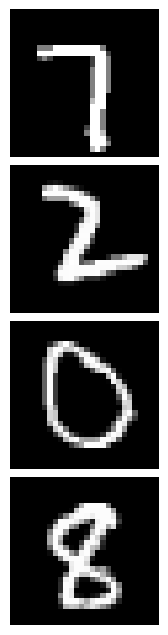

In [ ]:
num_images = 4

def plot_images(images, num_images=4, space=0.05, cmap='gray', vmax=None):
    plt.figure(figsize=(2, 8))
    for i in range(4):
        plt.subplot(4, 1, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap=cmap, vmax=vmax)
        plt.axis('off')
    plt.subplots_adjust(wspace=space, hspace=space)
    plt.show()


# Initialize images
start_index = 0  # Change this to select a different starting point
mnist_images, _ = zip(*[(test_data_mnist[i][0], test_data_mnist[i][1]) for i in range(start_index, start_index + 64)])

# Plot the images
plot_images(mnist_images, space=0.05, vmax=1)

#### Noisy images

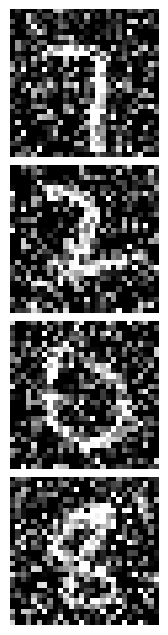

In [ ]:
torch_images_mnist = torch.stack(mnist_images)

noisy_images_mnist = add_gaussian_noise(torch_images_mnist, 0.5)
plot_images(noisy_images_mnist, space=0.05, vmax=1)

### Linear

#### Linear DAE

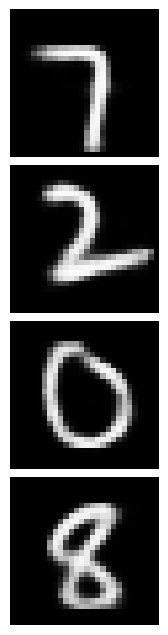

In [ ]:
noisy_images_flattened_mnist = noisy_images_mnist.view(noisy_images_mnist.size(0), -1).to(device)

with torch.no_grad():
    _, predictions_mean_mnist, predictions_var_mnist = loaded_models_mnist['linear_dae_mnist'].sample_predict(noisy_images_flattened_mnist, 50)

plot_images(predictions_mean_mnist.view(-1,28,28).cpu(), space=0.05, vmax=1)

#### Linear BDAE

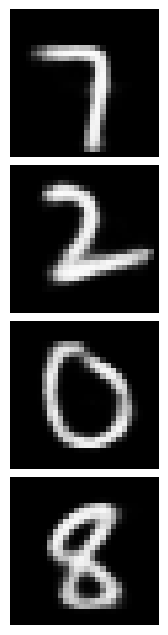

In [ ]:
with torch.no_grad():
    _, predictions_mean_mnist, predictions_var_mnist = loaded_models_mnist['linear_bdae_mnist'].sample_predict(noisy_images_flattened_mnist, 50)

plot_images(predictions_mean_mnist.view(-1,28,28).cpu(), space=0.05, vmax=1)

#### Model uncertainty Linear BDAE

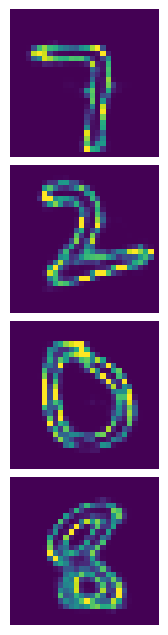

In [ ]:
plot_images(predictions_var_mnist.view(-1,28,28).cpu(), space=0.05, cmap='viridis', vmax=0.03)

### Convolutional

#### Convolutional DAE

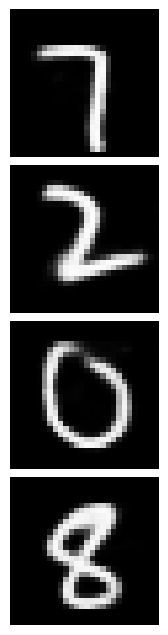

In [ ]:
with torch.no_grad():
    _, predictions_mean_mnist, predictions_var_mnist = loaded_models_mnist['convolutional_dae_mnist'].sample_predict(noisy_images_mnist.to(device), 50)

plot_images(predictions_mean_mnist.view(-1,28,28).cpu(), space=0.05, vmax=1)

#### Convolutional BDAE

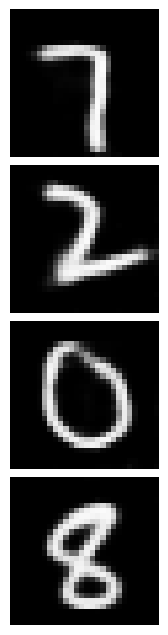

In [ ]:
with torch.no_grad():
    _, predictions_mean_mnist, predictions_var_mnist = loaded_models_mnist['convolutional_bdae_mnist'].sample_predict(noisy_images_mnist.to(device), 50)

plot_images(predictions_mean_mnist.view(-1,28,28).cpu(), space=0.05, vmax=1)

#### Model uncertainty Convolutional BDAE

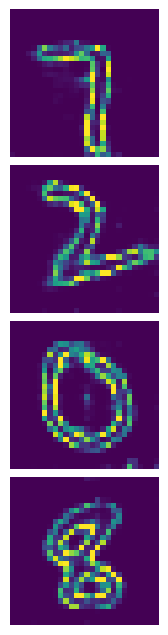

In [ ]:
plot_images(predictions_var_mnist.view(-1,28,28).cpu(), space=0.05, cmap='viridis', vmax=0.03)

## Evaluate on EMNIST

This section provides plots of individual examples of EMNIST dataset for the different models trained on MNIST dataset. These plots are used in the results section of my thesis.

### Preprocessing

#### Clean images

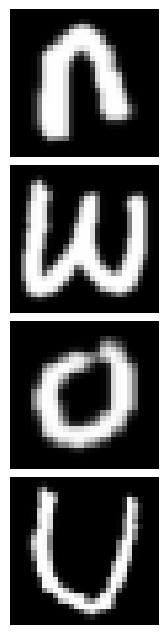

In [ ]:
# Download and load the EMNIST dataset
test_data_emnist = datasets.EMNIST(
                root='./data',
                download=True,
                split='letters',
                train=True,
                transform=transforms.Compose([
                    lambda img: transforms.functional.rotate(img, -90),
                    lambda img: transforms.functional.hflip(img),
                    transforms.ToTensor()
                ])
            )
emnist_loader = torch.utils.data.DataLoader(emnist_dataset, batch_size=64, shuffle=True)

# Initialize images
# Get a different set of 8 images and their labels from the test dataset
start_index = 0  # Change this to select a different starting point
images_emnist, labels = zip(*[(emnist_dataset[i][0], emnist_dataset[i][1]) for i in range(start_index, start_index + 64)])

# Plot the images
plot_images(images_emnist, space=0.05, vmax=1)

#### Noisy images

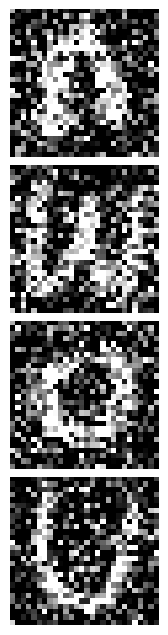

In [ ]:
torch_images_emnist = torch.stack(images_emnist)

noisy_images_emnist = add_gaussian_noise(torch_images_emnist, 0.5)
plot_images(noisy_images_emnist, space=0.05, vmax=1)

### Linear

#### Linear DAE

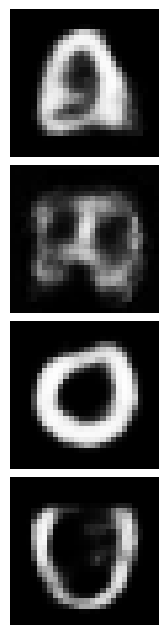

In [ ]:
noisy_images_flattened_emnist = noisy_images_emnist.view(noisy_images_emnist.size(0), -1).to(device)

with torch.no_grad():
    _, predictions_mean_emnist, predictions_var_emnist = loaded_models_mnist['linear_dae_mnist'].sample_predict(noisy_images_flattened_emnist, 50)

plot_images(predictions_mean_emnist.view(-1,28,28).cpu(), space=0.05, vmax=1)

#### Linear BDAE

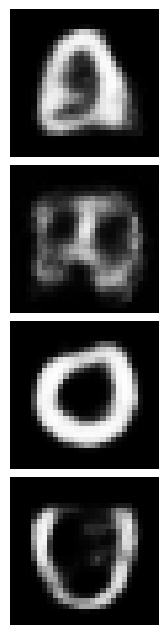

In [ ]:
with torch.no_grad():
    _, predictions_mean_emnist, predictions_var_emnist = loaded_models_mnist['linear_bdae_mnist'].sample_predict(noisy_images_flattened_emnist, 50)

plot_images(predictions_mean_emnist.view(-1,28,28).cpu(), space=0.05, vmax=1)

#### Model uncertainty Linear BDAE

0.048261724


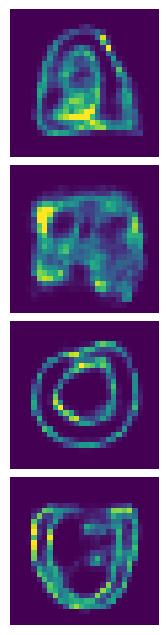

In [ ]:
plot_images(predictions_var_emnist.view(-1,28,28).cpu(), space=0.05, cmap='viridis', vmax=0.02)

### Convolutional

#### Convolutional DAE

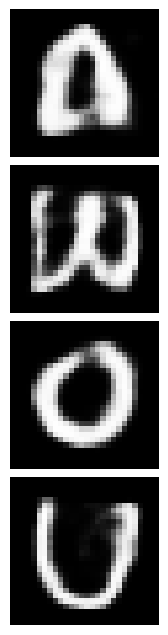

In [ ]:
with torch.no_grad():
    _, predictions_mean_emnist, predictions_var_emnist = loaded_models_mnist['convolutional_dae_mnist'].sample_predict(noisy_images_emnist.to(device), 50)

plot_images(predictions_mean_emnist.view(-1,28,28).cpu(), space=0.05, vmax=1)

#### Convolutional BDAE

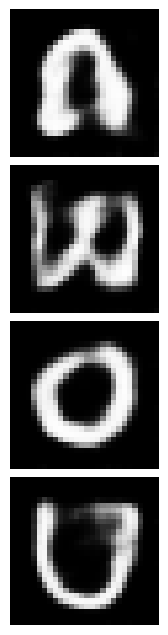

In [ ]:
with torch.no_grad():
    _, predictions_mean_emnist, predictions_var_emnist = loaded_models_mnist['convolutional_bdae_mnist'].sample_predict(noisy_images_emnist.to(device), 50)

plot_images(predictions_mean_emnist.view(-1,28,28).cpu(), space=0.05, vmax=1)

#### Model uncertainty Convolutional BDAE

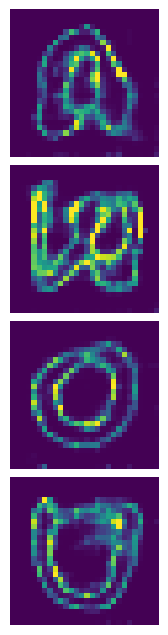

In [ ]:
plot_images(predictions_var_emnist.view(-1,28,28).cpu(), space=0.05, cmap='viridis', vmax=0.02)

## Evaluate on Fashion MNIST

This section provides plots of individual examples of Fashion-MNIST dataset for the different models used in this paper. These plots are used in the results section of my thesis.

### Preprocessing

#### Clean images

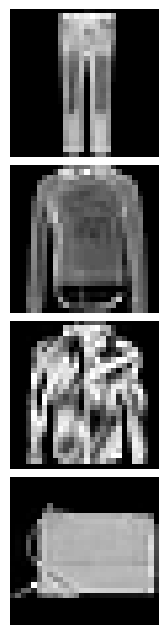

In [ ]:
num_images = 4

def plot_images(images, num_images=4, space=0.05, cmap='gray', vmax=None):
    plt.figure(figsize=(2, 8))
    for i in range(4):
        plt.subplot(4, 1, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap=cmap, vmax=vmax)
        plt.axis('off')
    plt.subplots_adjust(wspace=space, hspace=space)
    plt.show()


start_index = 0  # Change this to select a different starting point
fashion_images, _ = zip(*[(test_data_fashion[i][0], test_data_fashion[i][1]) for i in range(start_index, start_index + 64)])

# Plot the images
plot_images(fashion_images, space=0.05, vmax=1)

#### Noisy images

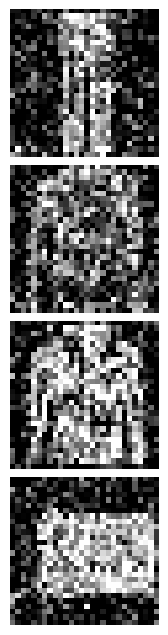

In [ ]:
torch_images_fashion = torch.stack(fashion_images)

noisy_images_fashion = add_gaussian_noise(torch_images_fashion, 0.3)
plot_images(noisy_images_fashion, space=0.05, vmax=1)

### Linear

#### Linear DAE

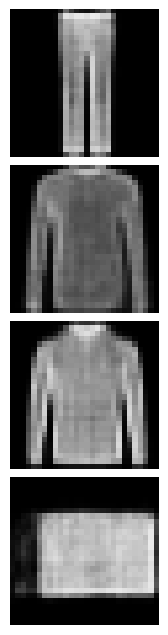

In [ ]:
noisy_images_flattened_fashion = noisy_images_fashion.view(noisy_images_fashion.size(0), -1).to(device)

with torch.no_grad():
    _, predictions_mean_fashion, predictions_var_fashion = loaded_models_fashion['linear_dae_fashion'].sample_predict(noisy_images_flattened_fashion, 50)

plot_images(predictions_mean_fashion.view(-1,28,28).cpu(), space=0.05, vmax=1)

#### Linear BDAE

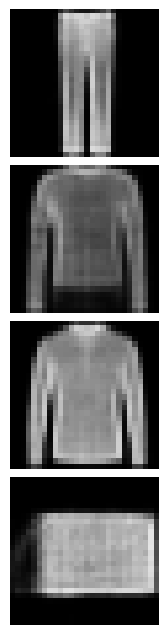

In [ ]:
with torch.no_grad():
    _, predictions_mean_fashion, predictions_var_fashion = loaded_models_fashion['linear_bdae_fashion'].sample_predict(noisy_images_flattened_fashion, 50)

plot_images(predictions_mean_fashion.view(-1,28,28).cpu(), space=0.05, vmax=1)

#### Model uncertainty Linear BDAE

0.030419078


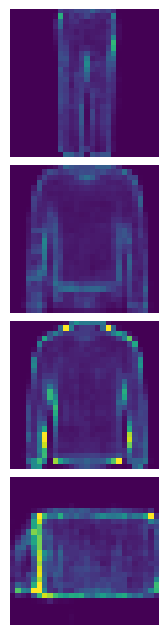

In [ ]:
plot_images(predictions_var_fashion.view(-1,28,28).cpu(), space=0.05, cmap='viridis', vmax=0.03)

### Convolutional

#### Convolutional DAE

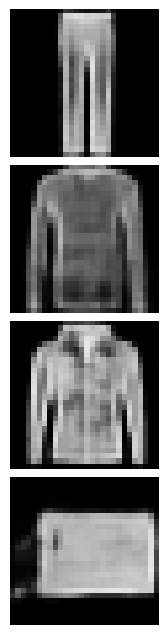

In [ ]:
with torch.no_grad():
    _, predictions_mean_fashion, predictions_var_fashion = loaded_models_fashion['convolutional_dae_fashion'].sample_predict(noisy_images_fashion.to(device), 50)

plot_images(predictions_mean_fashion.view(-1,28,28).cpu(), space=0.05, vmax=1)

#### Convolutional BDAE

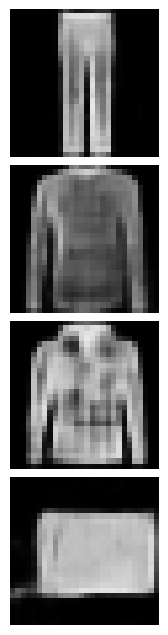

In [ ]:
with torch.no_grad():
    _, predictions_mean_fashion, predictions_var_fashion = loaded_models_fashion['convolutional_bdae_fashion'].sample_predict(noisy_images_fashion.to(device), 50)

plot_images(predictions_mean_fashion.view(-1,28,28).cpu(), space=0.05, vmax=1)

#### Model uncertainty Convolutional BDAE

0.10735768


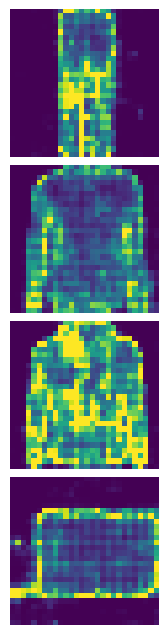

In [ ]:
plot_images(predictions_var_fashion.view(-1,28,28).cpu(), space=0.05, cmap='viridis', vmax=0.03)

## Sensitivity Analysis: MNIST for increased noise

In this section, the MNIST images for increasing noise level are the input of a model trained on noies level 0.5.

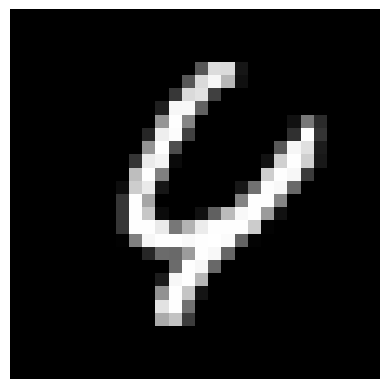

In [ ]:
i = 0  # Change this index to get a different image

# Retrieve the i-th image and its label
image, _ = test_data_mnist[i]

plt.imshow(image.squeeze(), cmap='gray')
plt.axis('off')
plt.show()

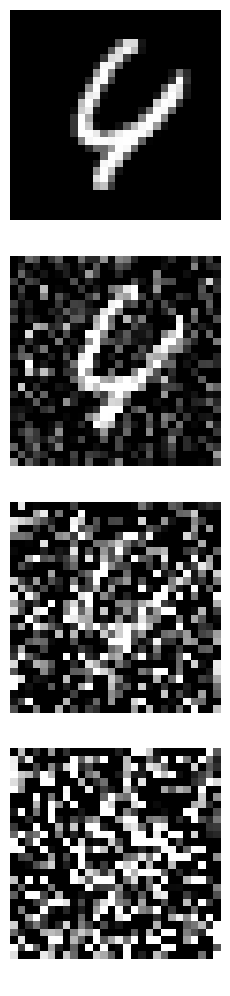

In [ ]:
# Define the noise levels
noise_levels = [0.0, 0.3, 0.6, 0.9]

fig, axs = plt.subplots(4, 1, figsize=(5, 10))

noisy_images = []

# Plot the images with different levels of Gaussian noise
for idx, noise_level in enumerate(noise_levels):
    noisy_image = add_gaussian_noise(image, noise_factor=noise_level)
    noisy_images.append(noisy_image)

    axs[idx].imshow(noisy_image.squeeze(), cmap='gray')
    axs[idx].set_title(f" ", y=-0.15)
    axs[idx].axis('off')

# Show the plot
plt.tight_layout()
plt.show()

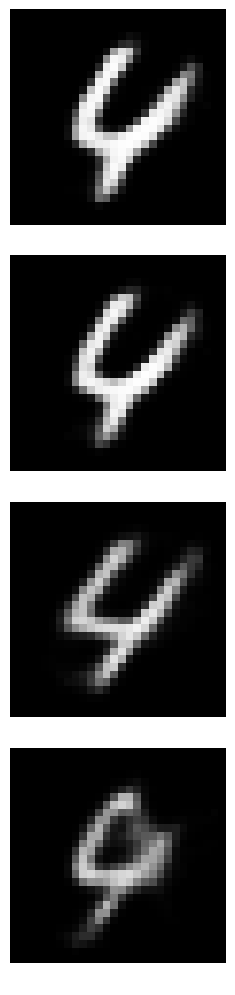

In [ ]:
# Define the noise levels and corresponding models
models = [loaded_models_mnist['linear_bdae_mnist']] * 4 # Change model to 'linear_bdae_mnist', 'linear_dae_mnist', 'convolutional_bdae_mnist', 'convolutional_dae_mnist'

denoised_means = []
denoised_vars = []


for corrupted_image, model in zip(noisy_images, models):
    model.eval()
    predictions, predictions_mean, predictions_var = model.sample_predict(corrupted_image.view(-1, 28*28).to(device), 100)
    denoised_vars.append(predictions_var.view(28,28).cpu().detach().numpy())

fig, axs = plt.subplots(4, 1, figsize=(5, 10))

# Plot the denoised images
for idx, denoised_image in enumerate(denoised_means):
    axs[idx].imshow(denoised_image, cmap='gray', vmax=1)
    axs[idx].set_title(f"   ", y=-0.12)
    axs[idx].axis('off')

# Show the plot
plt.tight_layout()
plt.show()

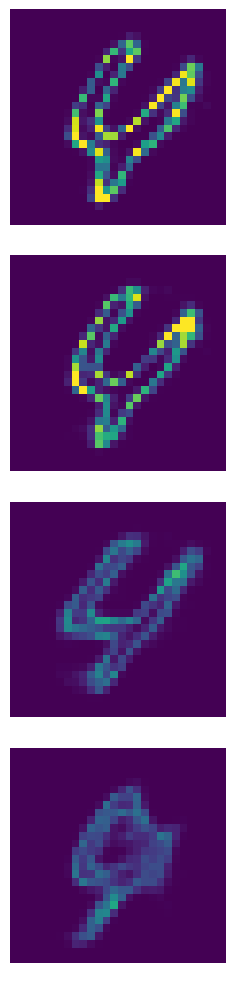

In [ ]:
fig, axs = plt.subplots(4, 1, figsize=(5, 10))

for idx, denoised_image in enumerate(denoised_vars):

    mean_variance = np.mean(denoised_image)

    axs[idx].imshow(denoised_image, cmap='viridis', vmax=0.02)

    axs[idx].set_title(f"   ", y=-0.12)
    axs[idx].axis('off')

# Show the plot
plt.tight_layout()
plt.show()